# 1 Introduction

Welcome to the fifth practical session of CS233 - Introduction to Machine Learning.  
In this exercise class, we will work with higher-dimensional feature spaces.  

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%load_ext autoreload
%autoreload 2

# 2 Cover's theorem

In this week's lecture we have encountered Cover's theorem:  

$\textit{"A complex pattern-classification problem, cast in a high-dimensional space nonlinearly  
is more likely}$ 
$\textit{to be linearly separable than in a low-dimensional space, provided that the space is not densely populated."}$

Within this exercise we will empirically validate Cover's theorem by simulating toy data 
and by re-using the perceptron code of last week's exercises.

**Note**: The slides use a slightly different notation where, $p$ is number of $N$- dimensional data points. To keep things coherent with the previous exercises we use, N and D. N- number of data points and D is their dimentionality.

# 2.1 Generate data

To train our perceptron we create a synthetic data set $\left(X,y\right)$. X is a $\left[ N \times D \right]$ matrix of observations $x_{i=1,...,N}$ with entries $x_{i,j=1,...,D} \stackrel{i.i.d.}{\sim} Bernoulli(\lambda=0.5)$. y is a $\left[ N \times 1 \right]$ vector of target values $y_{i=1,...,N} \stackrel{i.i.d.}{\sim} Bernoulli(\lambda=0.5)$.  
Write a function `sample_data` that returns a synthetic data set $\left(X,y\right)$ given $N$ and $D$.

Hint: You can draw $50$ samples from a Bernoulli distribution $Bernoulli(\lambda=0.5)$ via

In [2]:
import numpy as np
lamb, D = 0.5, 50
np.random.binomial(1, lamb, D)

array([0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 1])

Please fill in the function `sample_data` below:

In [5]:
def sample_data(N,D):
    """
    generate the synthetic data.
    X is of size [N x D]
    y is of size [N] 
    """
    
    """
    Please fill in the required code here
    """
    
    X = np.random.binomial(1, lamb, (N, D))
    y = np.random.binomial(1, lamb, N)
        
    # if all target labels are identical then flip a label 
    # (some perceptron implementations require at least two different label values)
    if len(np.unique(y))==1: y[0] = 1-y[0]
    return X, y

# 2.2 Simulation

We wish to evaluate the fraction $f$ of $r$ runs for which $\left(X,y\right)$ is linearly separable and evaluate this fraction as a function of $N$: Within a function `simulate`, systematically vary $N \in \left(1,200\right]$ and set $D=50, r=30$. For each $N$ call a function `run_trial` that generates a data set as described in section 2.1 and trains a perceptron on it. Count the number $r_+$ out of the $r$ trials that are linearly separable and plot $f(N) = \frac{r_+(N)}{r}$ over $N/D$.  
The outcome should resemble the figure on slide $12$ ("Numerical Approximation") of this week's lecture.  

Hints: Feel free to use your own perceptron code but keep in mind that for some instances the perceptron may not converge.  
For plotting you can use the provided function `plotC`.

Please fill in the functions `simulate` and `run_trial` below:

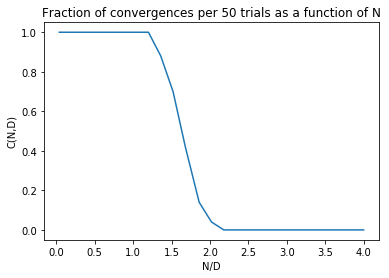

In [14]:
import numpy as np
from plots import plotC
from helpers import Perceptron

def run_trial(N, D):
    """
    generate one trial of data and run the perceptron on it
    X is of size [N x D]
    y is of size [N]
    """
    # call sample_data
    X, y = sample_data(N, D)
    
    # append a constant value to the input for the bias
    # such that X is of size [N x D+1]
    X = np.concatenate((np.ones((N, 1)), X), axis=1)
    # initialize weights w
    w = np.random.rand(D + 1)
    
    # run the perceptron
    _,num_errs = Perceptron(X, y, w, lr=0.1, n_epochs=100)
    # the data is linearly separable if and only if the perceptron
    # classifies the given data with zero error
    linSep   = num_errs == 0  
    
    return linSep

def simulate():
    """run a simulation generating & classifying data sets for a varying sample size"""
    trials = 50 # number of trials per parameter 
    D  = 50 # dimensionality of each observation

    domain = np.round(np.linspace(2,200,25)).astype(int)
    fracts = np.empty(len(domain))
    for pdx, N in enumerate(domain):
        # initialize the count of linearly separable trials
        linSep = 0
        for trial in range(trials):
            # set random number generator as a function of trial number
            # to make results comparable across conditions & get smoother C(N,D) curve
            np.random.seed(trial)
            linSep += run_trial(N, D)
            # compute the fraction of these problems for which the
            # perceptron learning rule converges
            fracts[pdx] = linSep / trials
    plotC(fracts, D, trials)

simulate()

**Questions:**  
* Justify the shape of the observed curve! Why does the Perceptron fail when the number of dimensions is less than the number of data points?
* In this exercise we randomly sampled data points. Is this distribution representative of real data? Why (not)?
* Toy around with different values of $N$ and $D$. What do you observe?

# 3 Kernel trick

In this week's lecture we have heard of the benefits of higher-dimensional feature spaces for linear classifiers. To obtain higher-dimensional data one may  
* directly map observations into a higher-dimensional feature space or 
* make use of a kernel term that can be utilized to compute a dot product in a latent higher-dimensional space

Within this exercise we will encounter both techniques and kernelize the previously encountered perceptron.

# 3.1 XOR problem

Let us define the following toy data set  

In [38]:
def simData():
    """construct a XOR problem toy data set"""
    X = np.array([[0,0,1,1],[1,0,1,0]]).T
    y = np.array([1,0,0,1])
    
    return X, y

X, y = simData()
w = np.random.rand(2)
_,num_errs = Perceptron(X, y, w, lr=0.1, n_epochs=2000)
print(num_errs)

3


**Question:**
* Does training a perceptron on this data set converge? Why (not)?

Use the provided function `plot3Dscatter` to plot the given data set.
* Consider the function $\phi(\mathbf{x_1}): {\rm I\!R}^d \xrightarrow{} {\rm I\!R}^m, \left[ x_{11},x_{12}\right] \xrightarrow{} \left[ x_{11}^2, x_{12}^2, \sqrt{2} x_{11} x_{12} \right]$ for $\mathbf{x} \in X$ and $d=2,m=3$. Write a function `transform_data` that transforms the given data set accordingly. 

**Question:**  
Does training a perceptron on this data set converge? Why (not)? Use the provided function `plot3Dscatter` to plot the transformed data set.

Please fill in the function `transform_data` below:

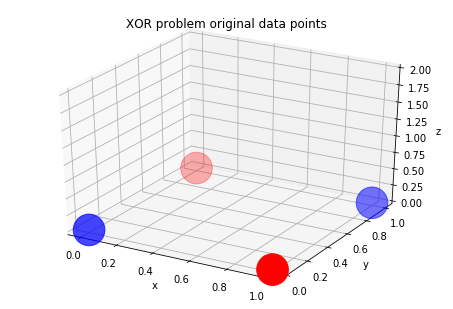

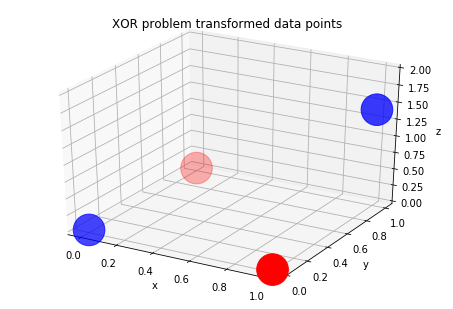

In [50]:
from plots import plot3Dscatter

def transform_data(X):
    X = X ** 2
    
    col = np.sqrt(2) * np.prod(X, axis=1)[:, np.newaxis]
    
    return np.concatenate((X, col), axis=1)

X, y = simData()
plot3Dscatter(X)
plot3Dscatter(transform_data(X))

# 3.2 Kernels

A kernel $k$ is a function $k(\mathbf{x_1},\mathbf{x_2}): {\rm I\!R}^d \times {\rm I\!R}^d \xrightarrow{} {\rm I\!R}, \left( \mathbf{x_1},\mathbf{x_2}\right) \xrightarrow{} \phi(\mathbf{x_1})^T\phi(\mathbf{x_2})$ for $\mathbf{x_1},\mathbf{x_2} \in X$, $d\in {\rm I\!N}$ and a given function $\phi(\mathbf{x})$. 

Notice how computing $k$ directly does not involve projecting the data to feature space ${\rm I\!R}^m$ as an intermediate step (as in the case of computing $\phi$).  

**Question:**  
* Show that the kernel $k(\mathbf{x_1},\mathbf{x_2}) = (\mathbf{x_1}^T\mathbf{x_2})^2$ implicitly specifies the feature transformation $\phi(\mathbf{x_1}) = \left[ x_{11}^2, x_{12}^2, \sqrt{2} x_{11} x_{12} \right]$ of section 3.1.
* This is known as the kernel trick. What does the kernel trick imply in terms of computational runtime? When is it (not) beneficial?

# 3.3 [Kernel perceptron](https://en.wikipedia.org/wiki/Kernel_perceptron)

* One can express the perceptron's weight vector $w$ as a linear combination $w=\sum_i \alpha_i y_i \phi(x_i)$ with $\alpha_i$ the number of times that observation $x_i$ was misclassified such that

\begin{align}
  y_{pred} & = \mathbf{w}^\mathsf{T} \phi(\mathbf{x}) \\
          & = \left( \sum_i^n  \alpha_i y_i \phi(\mathbf{x}_i) \right)^\mathsf{T} \phi(\mathbf{x}) \\
          & =  \sum_i^n \alpha_i y_i k(\mathbf{x}_i \cdot \mathbf{x}) \\
  \hat{y} & = sign(y_{pred})
\end{align}

Hence, final class is represented by $\hat{y}$.  
Use this term to write a perceptron involving the kernel $k(\mathbf{x_1},\mathbf{x_2})$ defined as in section 3.2.

* Run the perceptron on the data $\left( X,y \right)$ transformed via $\phi(\mathbf{x})$ as defined in section 3.1.  

**Question:**  
* What do you observe?  

Please fill in the functions `kernel` and `kernelizedPrediction` below:

In [51]:
def kernel(x,x_): 
    """
    Kernel which takes two inputs and
    returns scalar value. Implement Kernel
    as discussed in section 3.2
   
    x: data point
    x_: data point
    
    Return: float value according to kernel
        
    """
    return pow(np.dot(x, x_), 2)

In [68]:
def kernelizedPrediction(X, y, alpha, idx):
    """
    kernelized prediction function
    Implement y_pred as in the equation above
    X: data points
    y: data label
    alpha: number of misclassification of each data point
    idx: index of data point for which prediction is to be made
    
    Return: float
    """
    return np.sum(np.array([alpha[i] * y[i] * kernel(X[i], X[idx]) for i in range(X.shape[0])]))

Following implementation of Kernel Preceptron Learning is provided for you. Please, go through to understand the update step better

In [69]:
def predict(X, y, alpha, idx):
    """predict label of observation"""
    prediction   = kernelizedPrediction(X, y, alpha, idx)
    heaviside    = prediction >= 0
    rescale_pred = (heaviside - 0.5) * 2.0
    return rescale_pred
            
def KernelPerceptron(X, y, alpha, lr=1.0, n_epochs=100):
    """kernelized perceptron"""
    # in case the target labels should be {0,1} then remap to {-1,1}
    y[y==0]     = -1    
    num_samples = X.shape[0]

    for ep in range(n_epochs):
        # draw indices randomly
        idxs = np.random.permutation(num_samples)
        
        num_errs = 0 # count errors within current epoch
        for idx in idxs:
            
            # check whether the current observation was classified correctly
            correct = predict(X, y, alpha, idx) == y[idx]

            # Update error counts
            if not correct:
                alpha[idx] += lr*1
                num_errs   += 1
                
        # stopping criterion
        if num_errs == 0: break
    return alpha, num_errs

### Putting things together 
Here we call 
* Simple Perceptron with transformed data 
* Kernelized Perceptron

Run to see that both now produce zero error

In [70]:
from helpers import Perceptron
# get the data and apply transform
X, y    = simData()
X_trans = transform_data(X)

# append a bias to the data
X       = np.concatenate([np.ones((4,1)),X],1)
X_trans = np.concatenate([np.ones((4,1)),X_trans],1)

# initialize the weight vector and run the perceptron
w_3D    = np.array([0., 1., 1., 1.])
w_final, num_errs = Perceptron(X_trans, y, w_3D)
print("The perceptron learned to classify (X,y) with {} errors.".format(num_errs))

# initialize the error vector and run the kernel perceptron
alpha = np.zeros(X.shape[0])
alpha_final, num_errs_kernel = KernelPerceptron(X, y, alpha)
print("The kernel perceptron learned to classify (X,y) with {} errors.".format(num_errs_kernel))

The perceptron learned to classify (X,y) with 0 errors.
The kernel perceptron learned to classify (X,y) with 0 errors.
